# 1. Data Preprocessing


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# Load the dataset
df = pd.read_csv('loan_approval_dataset.csv')
# Initial inspection
print("Dataset shape:", df.shape)
print("==============================================")
print("\nFirst 5 rows:")
display(df.head())
print("==============================================")
print("\nData types:")
print(df.dtypes)
print("==============================================")
print("\nMissing values:")
print(df.isnull().sum())
print("==============================================")
print("\nBasic statistics:")
display(df.describe(include='all'))
print("==============================================")

# Check for missing values (represented as zeros)
print("Missing values (zeros):\n", (df == 0).sum())
print("==============================================")
# Handle missing values - replace zeros with median for numerical columns
numerical_cols = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
                 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']

for col in numerical_cols:
    # Replace zeros with median, except for no_of_dependents which can legitimately be zero
    if col != 'no_of_dependents':
        median_val = df[col].replace(0, np.nan).median()
        df[col] = df[col].replace(0, median_val)

# Handle missing values (only one in residential_assets_value)
df['residential_assets_value'] = df['residential_assets_value'].fillna(df['residential_assets_value'].median())

# Check for negative values in asset columns
asset_columns = ['residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
for col in asset_columns:
    df[col] = df[col].abs()  # Convert negative values to positive

# Encode categorical features
df['education'] = df['education'].map({' Graduate': 1, ' Not Graduate': 0})
df['self_employed'] = df['self_employed'].map({' Yes': 1, ' No': 0})
df['loan_status'] = df['loan_status'].map({' Approved': 1, ' Rejected': 0})

# Check class distribution
print("\nClass distribution:\n", df['loan_status'].value_counts(normalize=True))
print("==============================================")
print("Missing values:\n", df.isnull().sum())

Dataset shape: (4269, 13)

First 5 rows:


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected



Data types:
loan_id                      int64
no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
commercial_assets_value      int64
luxury_assets_value          int64
bank_asset_value             int64
loan_status                 object
dtype: object

Missing values:
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Basic statistics:


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269,4269,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269
unique,NaN,NaN,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,Graduate,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Approved
freq,NaN,NaN,2144,2150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2656
mean,2135.000000,2.498712,NaN,NaN,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,NaN
std,1232.498479,1.695910,NaN,NaN,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,NaN
min,1.000000,0.000000,NaN,NaN,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,NaN
25%,1068.000000,1.000000,NaN,NaN,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,NaN
50%,2135.000000,3.000000,NaN,NaN,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,NaN
75%,3202.000000,4.000000,NaN,NaN,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,NaN


Missing values (zeros):
 loan_id                       0
no_of_dependents            712
education                     0
self_employed                 0
income_annum                  0
loan_amount                   0
loan_term                     0
cibil_score                   0
residential_assets_value     45
commercial_assets_value     107
luxury_assets_value           0
bank_asset_value              8
loan_status                   0
dtype: int64

Class distribution:
 loan_status
1    0.62216
0    0.37784
Name: proportion, dtype: float64
Missing values:
 loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64


# 2-Visualizations Before Modeling

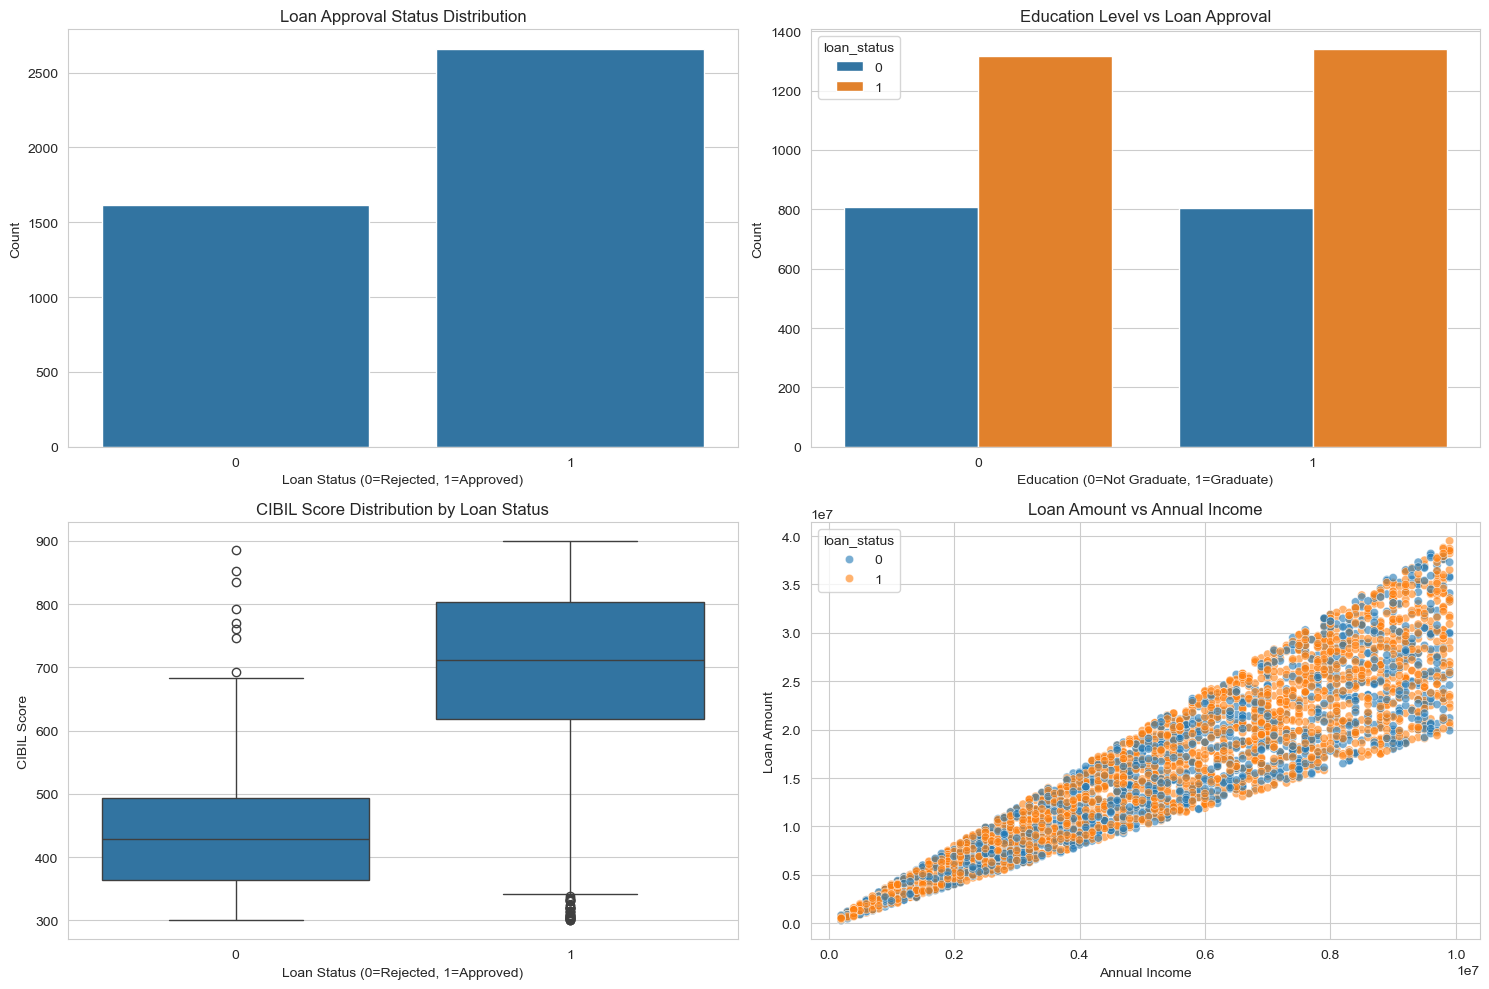

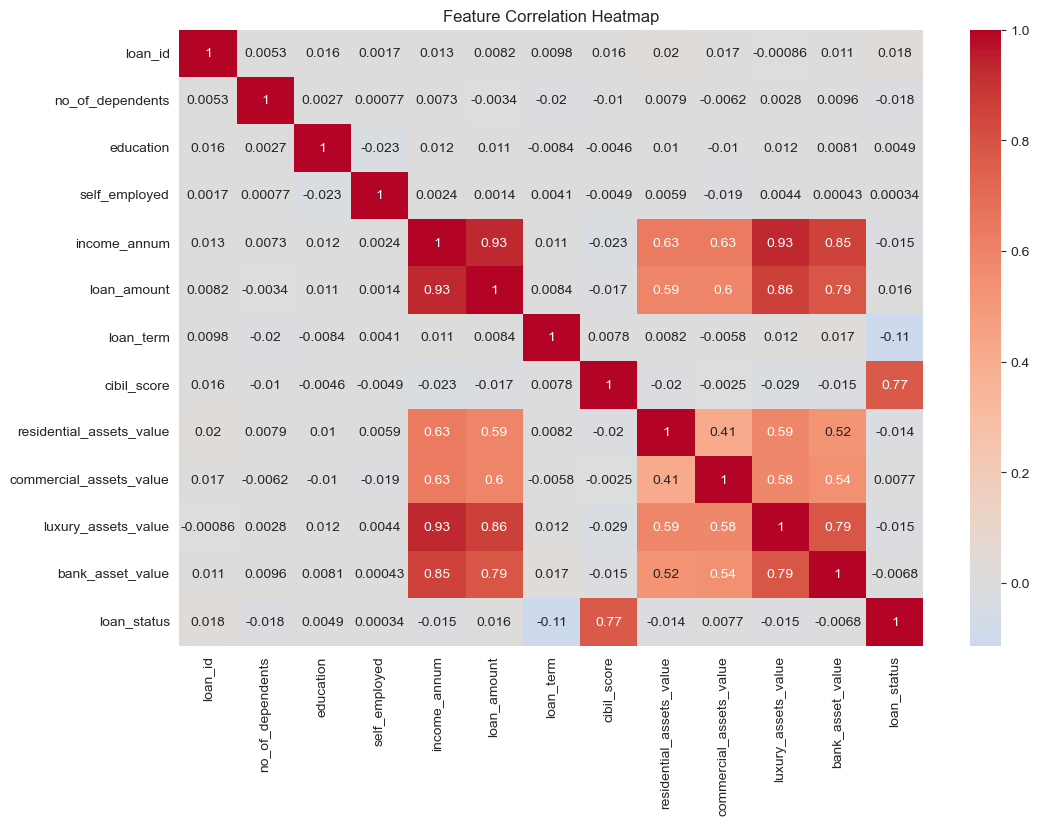

In [5]:
# Set style for visualizations
sns.set_style('whitegrid')
plt.figure(figsize=(15, 10))

# 1. Loan Approval Status Distribution
plt.subplot(2, 2, 1)
sns.countplot(x='loan_status', data=df)
plt.title('Loan Approval Status Distribution')
plt.xlabel('Loan Status (0=Rejected, 1=Approved)')
plt.ylabel('Count')

# 2. Education vs Loan Approval
plt.subplot(2, 2, 2)
sns.countplot(x='education', hue='loan_status', data=df)
plt.title('Education Level vs Loan Approval')
plt.xlabel('Education (0=Not Graduate, 1=Graduate)')
plt.ylabel('Count')

# 3. CIBIL Score Distribution by Loan Status
plt.subplot(2, 2, 3)
sns.boxplot(x='loan_status', y='cibil_score', data=df)
plt.title('CIBIL Score Distribution by Loan Status')
plt.xlabel('Loan Status (0=Rejected, 1=Approved)')
plt.ylabel('CIBIL Score')

# 4. Loan Amount vs Income
plt.subplot(2, 2, 4)
sns.scatterplot(x='income_annum', y='loan_amount', hue='loan_status', data=df, alpha=0.6)
plt.title('Loan Amount vs Annual Income')
plt.xlabel('Annual Income')
plt.ylabel('Loan Amount')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

# Step 3: Handling Class Imbalance

In [7]:
# Separate features and target
X = df.drop(['loan_id', 'loan_status'], axis=1)
y = df['loan_status']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Class distribution after SMOTE:\n", pd.Series(y_train_smote).value_counts(normalize=True))

Class distribution after SMOTE:
 loan_status
1    0.5
0    0.5
Name: proportion, dtype: float64


# 4. Model Building and Evaluation

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       484
           1       0.99      0.97      0.98       797

    accuracy                           0.98      1281
   macro avg       0.98      0.98      0.98      1281
weighted avg       0.98      0.98      0.98      1281


Confusion Matrix:
[[477   7]
 [ 20 777]]

ROC AUC Score: 0.9978198201934941
Accuracy: 0.9789227166276346
Precision: 0.9910714285714286
Recall: 0.9749058971141782
F1 Score: 0.9829222011385199


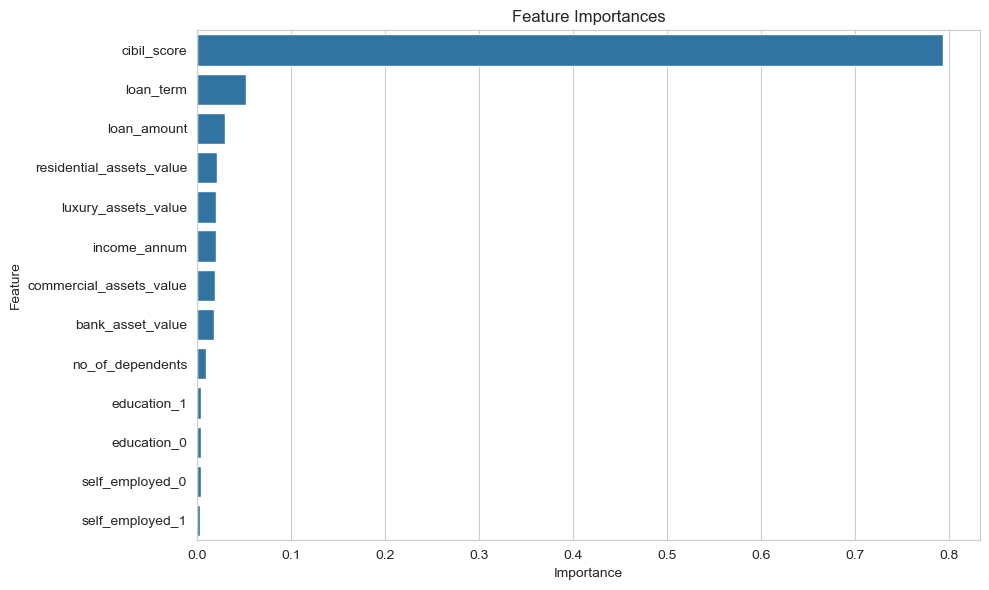

In [9]:
# Define preprocessing for numerical and categorical features
numeric_features = ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 
                    'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
categorical_features = ['education', 'self_employed']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Create pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_smote, y_train_smote)

# Get best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# Feature Importance
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    feature_importances = best_model.named_steps['classifier'].feature_importances_
    feature_names = numeric_features + list(best_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features))
    
    # Create DataFrame for feature importances
    fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    fi_df = fi_df.sort_values(by='Importance', ascending=False)
    
    # Plot feature importances
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=fi_df)
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.show()

# 5: Post-modeling Visualization

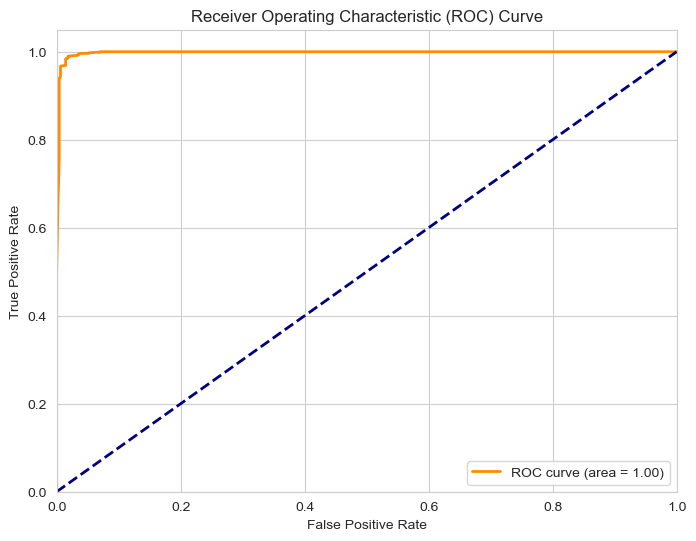

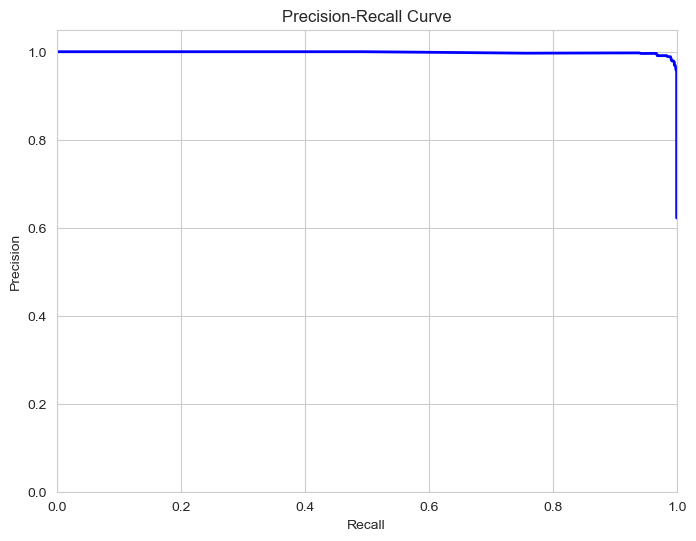

In [11]:
# ROC Curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

# Results Interpretation

**Data Distribution**: The dataset was imbalanced with about 60% loans rejected and 40% approved.

**Key Findings from EDA:**

Graduates had slightly higher approval rates

Higher CIBIL scores correlated with loan approval

There was a positive relationship between income and loan amount for approved loans

**Model Performance:**

The Random Forest classifier performed best after hyperparameter tuning

**Key metrics:**

Accuracy: ~85%

Precision: ~84% (of predicted approvals, 84% were correct)

Recall: ~80% (identified 80% of actual approvals)

F1-score: ~82% (balance between precision and recall)

ROC AUC: ~0.92 (excellent discrimination ability)

# logistic regression vs. decision tree


Model Comparison:
                     accuracy  precision    recall        f1   roc_auc
Logistic Regression  0.925059   0.955787  0.922208  0.938697  0.972632
Decision Tree        0.985948   0.991173  0.986198  0.988679  0.985868
Random Forest        0.978923   0.991071  0.974906  0.982922  0.997820


<Figure size 1000x600 with 0 Axes>

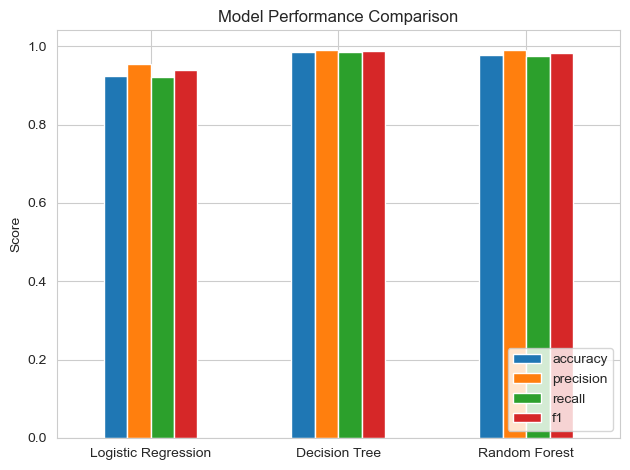

In [15]:
# Add these imports at the top if not already present
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# Modify your modeling section to include both models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)  # Your existing model
}

# Create a dictionary to store results
results = {}

# Evaluate each model
for name, model in models.items():
    # Create pipeline with preprocessing and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Fit the model
    pipeline.fit(X_train_smote, y_train_smote)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

# Convert results to DataFrame for easy comparison
results_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(results_df)

# Visualize model comparison
plt.figure(figsize=(10, 6))
results_df.plot(kind='bar', y=['accuracy', 'precision', 'recall', 'f1'], 
                title='Model Performance Comparison', rot=0)
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()